# Simple Neural Network Example 

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from torch.utils.data import Dataset

# Hyper Parameters 

In [64]:
# set seed for reproducibility
seed = 316
np.random.seed(seed)
torch.manual_seed(seed)


# hyperparameters
learning_rate = 0.02
batch_size = 3000
num_epochs = 8

title = 'Diff LR  epoch=' +str(num_epochs) + 'batch=' + str(batch_size)

# Load Data and Preprocessing

In [65]:
# Load the simulated dataset
pat_array = np.load('simulated_dataset.npy')

# Define events and drug lists
events = ['BetaB', 'Statins', 'AcidR', 'Vioxx', 'HT', 'HC', 'Arthritis', 'MI']
drug = ['BetaB', 'Statins', 'AcidR', 'Vioxx']

# Define the data type for each patient
dtype = [('age', int), ('CVR', float)] + [(var, int) for var in events]

n_pat = 1000  # Number of patients
unit = 100    # Days per unit (window size)
days = pat_array.shape[1]  # Total number of days in the dataset
dat_subset = pat_array[:, :days, -8:]  # Subset the array to include only the last 8 event columns

# Function to summarize the data by per 100 days
def summarize_data(dat_subset, n_pat, n_unit, unit):
    dat_sum = np.empty((n_pat, n_unit, 8), dtype=bool)
    for j in range(n_unit):
        start_day = j * unit
        end_day = (j + 1) * unit
        dat_sum[:, j, :] = np.any(dat_subset[:, start_day:end_day, :], axis=1)
    return dat_sum.astype(float)

# Calculate the number of units (time windows)
n_unit = days // unit

# Summarize the data
dat_sum = summarize_data(dat_subset, n_pat, n_unit, unit)

# Function to create paired input and output for the model
def create_data_pairs(dat_sum, n_pat, n_unit):
    n_pairs = n_unit - 1  # Number of pairs (input-output)
    random_order = np.random.permutation(n_pairs)  # Shuffle the time order
    data_pairs = np.empty((n_pairs * n_pat, 2, 8), dtype=float)
    
    index = 0
    for j in random_order:
        for i in range(n_pat):
            data_pairs[index, 0, :] = dat_sum[i, j, :]      # Input data (current unit)
            data_pairs[index, 1, :] = dat_sum[i, j + 1, :]  # Output data (next unit)
            index += 1
    return data_pairs

# Create paired input-output data for the model
data_pairs = create_data_pairs(dat_sum, n_pat, n_unit)


In [79]:
data_pairs.shape

(35000, 2, 8)

- We subsetted data and summarizes it by checking if any event occurred within each 100-day window. The result is a summarized array where each value indicates the presence of any event within that window. The shape is (1000, 36,8)

- We generated pairs of input and output data for model training. It shuffles the time order to create randomized pairs, ensuring that the input corresponds to the data in one time unit and the output corresponds to the following time unit.The shape of data pair is (35000, 2, 8)



# Split Into Train Test Validation 

In [67]:
# Define indices to split the data into training, validation, and test sets
# The following two lines (commented out) show an alternative way to compute the split indices dynamically
# based on the total number of pairs (n_pairs) and the number of patients (1000).
n_pairs = days//unit -1
first_valid_index = int(n_pairs * 0.6 + 1) *1000
first_test_index = int(n_pairs * 0.8 + 1) *1000


# Split the data into training, validation, and test sets
train_data = data_pairs[:first_valid_index, :, :]                      # First 60% for training
val_data = data_pairs[first_valid_index:first_test_index, :, :]        # Next 20% for validation
test_data = data_pairs[first_test_index:, :, :]                        # Last 20% for testing

# Function to transform the data into a list of tuples for easier processing
def transform_data(data):
    transformed_data = []
    num_patients = 1000  # Number of patients
    total_samples = data.shape[0]  # Total number of samples in the data

    # Loop through each sample in the data
    for i in range(total_samples):
        patient_id = i % num_patients  # Assign a patient ID based on the sample index
        input_data = data[i, 0, :]     # Extract the input data (current time unit)
        output_data = data[i, 1, :]    # Extract the output data (next time unit)
        transformed_data.append((input_data, output_data, patient_id))  # Add the tuple to the list

    return transformed_data  # Return the transformed list of tuples

# Define a custom Dataset class for PyTorch
class PatientDataset(Dataset):
    def __init__(self, data):
        self.data = data  # Store the data (a list of tuples)

    def __len__(self):
        return len(self.data)  # Return the number of samples in the dataset

    def __getitem__(self, idx):
        # Extract input data, output data, and patient ID for the given index
        input_data, output_data, patient_id = self.data[idx]
        # Return a dictionary with input, output, and patient_id
        return {'input': input_data, 'output': output_data, 'patient_id': patient_id}

# Transform the training and validation data into lists of tuples
train_list = transform_data(train_data)
val_list = transform_data(val_data)

# Create Dataset objects for training and validation data
train_dataset = PatientDataset(train_list)
val_dataset = PatientDataset(val_list)

# Create DataLoader objects for training and validation datasets
# DataLoader is used to load data in batches, with optional shuffling
train_dlr = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle training data
val_dlr = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)     # No shuffle for validation

# Define a Simple NN Model

In [68]:
# -------------------------------- Simple Network Version 1 --------------------------------
class ModifiedNet(nn.Module):
    def __init__(self, num_patients=1000):
        super(ModifiedNet, self).__init__()
        # Define the layers of the network
        self.hidden_layer1 = nn.Linear(8, 3)  # First hidden layer: 8 input features to 3 output features
        self.hidden_layer2 = nn.Linear(3, 3)  # Second hidden layer: 3 input features to 3 output features
        self.output_layer = nn.Linear(3, 8)   # Output layer: 3 input features to 8 output features
        
        # Define a learnable parameter representing a hidden unit for each patient
        self.baseline_hidden_unit = nn.Parameter(torch.full((num_patients,), 0.5))
        
        # Define a learnable weight for adjusting the model output related to Myocardial Infarction (MI)
        self.baseline_to_MI_weight = nn.Parameter(torch.tensor(2.0))

    def forward(self, x, patient_id):
        # Pass the input through the first hidden layer and apply a sigmoid activation function
        x = torch.sigmoid(self.hidden_layer1(x))
        
        # Pass the result through the second hidden layer and apply a sigmoid activation function
        x = torch.sigmoid(self.hidden_layer2(x))
        
        # Pass the result through the output layer (no activation function applied yet)
        output = self.output_layer(x)

        # Clamp the baseline values between 0 and 1 to ensure they stay within this range
        baseline_values = torch.clamp(self.baseline_hidden_unit[patient_id], min=0, max=1)

        # Adjust the last output (assumed to be related to MI) using the baseline values and the learned weight
        mi_output_adjustment = self.baseline_to_MI_weight * baseline_values
        output[:, -1] += mi_output_adjustment

        # Apply a sigmoid activation function to the final output to ensure values are between 0 and 1
        output = torch.sigmoid(output)

        return output  # Return the final output


# ------------------------- Function for Training and Plotting -----------------------------

def train_and_evaluate(model, train_dlr, optimizer, criterion, epochs, weight_list):
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_train_loss = 0.0  # Variable to accumulate the training loss for the epoch

        for batch in train_dlr:
            inputs = batch['input'].float()  # Extract input data from the batch
            labels = batch['output'].float()  # Extract output labels from the batch
            patient_ids = batch['patient_id']  # Extract patient IDs from the batch

            optimizer.zero_grad()  # Clear previous gradients
            train_pred = model(inputs, patient_ids)  # Forward pass: predict outputs
            train_loss = criterion(train_pred, labels)  # Calculate loss
            train_loss.backward()  # Backward pass: compute gradients
            optimizer.step()  # Update model parameters
            
            running_train_loss += train_loss.item()  # Accumulate the loss

        avg_train_loss = running_train_loss / len(train_dlr)  # Calculate average training loss
        train_losses.append(avg_train_loss)  # Store the average training loss

        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0  # Variable to accumulate the validation loss

        with torch.no_grad():  # Disable gradient calculation during evaluation
            for batch in val_dlr:
                inputs = batch['input'].float()  # Extract input data from the batch
                labels = batch['output'].float()  # Extract output labels from the batch
                patient_ids = batch['patient_id']  # Extract patient IDs from the batch

                val_pred = model(inputs, patient_ids)  # Forward pass: predict outputs
                loss = criterion(val_pred, labels)  # Calculate loss
                val_loss += loss.item()  # Accumulate the loss

        avg_val_loss = val_loss / len(val_dlr)  # Calculate average validation loss
        val_losses.append(avg_val_loss)  # Store the average validation loss
        
        # Print the epoch's training and validation loss
        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

        # Clamp baseline values between 0 and 1 after each epoch (if applicable)
        with torch.no_grad():
            if hasattr(model, 'baseline_to_MI_weight'):
                model.baseline_hidden_unit.clamp_(min=0, max=1)
                weight_list.append(model.baseline_to_MI_weight.item())  # Store the current MI weight

    return train_losses, val_losses, weight_list  # Return the losses and the weight list


def plot_losses(train_losses, val_losses):
    # Plot training and validation losses over epochs
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Baseline Model: Training and Validation Losses')  # Title of the plot
    plt.xlabel('Epoch')  # Label for the x-axis (Epochs)
    plt.ylabel('Loss')  # Label for the y-axis (Loss)
    plt.legend()  # Display the legend
    plt.grid(True)  # Enable grid lines on the plot
    plt.show()  # Show the plot

def plot_roc_pr_curves(val_output, predictions, events, model_name):
    # Create subplots for ROC and Precision-Recall curves in a 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Plot ROC curves for the specified range of labels (first 4 labels)
    for i in range(4):  
        fpr, tpr, _ = roc_curve(val_output[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)

        # ROC curve
        axs[0, 0].plot(fpr, tpr, label=f'{events[i]} (AUC = {roc_auc:.3f})')
        axs[0, 0].set_xlabel('False Positive Rate')
        axs[0, 0].set_ylabel('True Positive Rate')
        axs[0, 0].set_title('4 Medication ROC Curves')
        axs[0, 0].legend(loc='lower right')

    # Plot Precision-Recall curves for the specified range of labels (first 4 labels)
    for i in range(4):  
        precision, recall, _ = precision_recall_curve(val_output[:, i], predictions[:, i])
        pr_auc = auc(recall, precision)

        # Precision-Recall curve
        axs[0, 1].plot(recall, precision, label=f'{events[i]} (Avg Precision = {pr_auc:.3f})')
        axs[0, 1].set_xlabel('Recall')
        axs[0, 1].set_ylabel('Precision')
        axs[0, 1].set_title('4 Medication Precision-Recall Curves')
        axs[0, 1].legend(loc='lower left')

    # Plot ROC curves for the remaining labels (last 4 labels)
    for i in range(4, 8):
        fpr, tpr, _ = roc_curve(val_output[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)

        # ROC curve
        axs[1, 0].plot(fpr, tpr, label=f'{events[i]} (AUC = {roc_auc:.3f})')
        axs[1, 0].set_xlabel('False Positive Rate')
        axs[1, 0].set_ylabel('True Positive Rate')
        axs[1, 0].set_title('4 Diseases ROC Curves')
        axs[1, 0].legend(loc='lower right')

    # Plot Precision-Recall curves for the remaining labels (last 4 labels)
    for i in range(4, 8):
        precision, recall, _ = precision_recall_curve(val_output[:, i], predictions[:, i])
        pr_auc = auc(recall, precision)

        # Precision-Recall curve
        axs[1, 1].plot(recall, precision, label=f'{events[i]} (Avg Precision = {pr_auc:.3f})')
        axs[1, 1].set_xlabel('Recall')
        axs[1, 1].set_ylabel('Precision')
        axs[1, 1].set_title('4 Diseases Precision-Recall Curves')
        axs[1, 1].legend(loc='upper right')

    plt.suptitle(model_name)  # Set the overall title for the plot
    plt.tight_layout()  # Adjust subplots to fit in the figure area
    plt.show()  # Show the plot


# Model Training

Epoch 1, Train Loss: 0.7059826329350471, Val Loss: 0.6248164176940918
Epoch 2, Train Loss: 0.5760613530874252, Val Loss: 0.5266518990198771
Epoch 3, Train Loss: 0.4986279793083668, Val Loss: 0.469673752784729
Epoch 4, Train Loss: 0.45425330102443695, Val Loss: 0.4382439951101939
Epoch 5, Train Loss: 0.4305717200040817, Val Loss: 0.42207137743632
Epoch 6, Train Loss: 0.4195062629878521, Val Loss: 0.41367627183596295
Epoch 7, Train Loss: 0.41259073093533516, Val Loss: 0.40926843881607056
Epoch 8, Train Loss: 0.4099986255168915, Val Loss: 0.4063538908958435
Elapsed time: 3.665574789047241 seconds


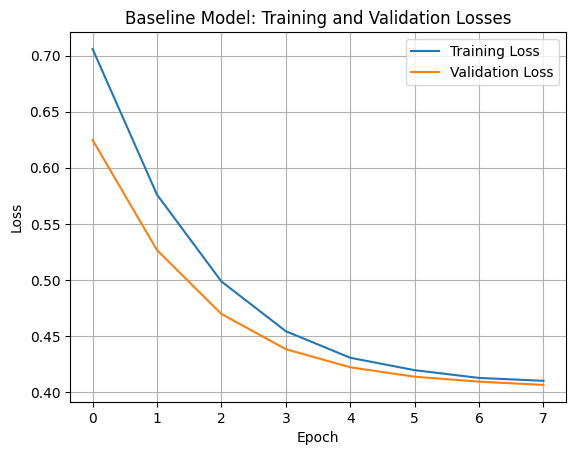

In [69]:
model = ModifiedNet()

# define different learning rate

baseline_lr = 0.6
default_lr = 0.3
params = [
    {'params': model.baseline_hidden_unit, 'lr': baseline_lr},
    {'params': model.baseline_to_MI_weight, 'lr': baseline_lr},
    {'params': model.hidden_layer1.parameters()},
    {'params': model.hidden_layer2.parameters()},
    {'params': model.output_layer.parameters()}
]
# optimizer = optim.SGD(params, lr=default_lr)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

weight_list = []

start_time = time.time()

train_losses, val_losses, weight_list = train_and_evaluate(
    model, train_dlr,
    optimizer, criterion, num_epochs, weight_list
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


plot_losses(train_losses, val_losses)

# Model Evaluation

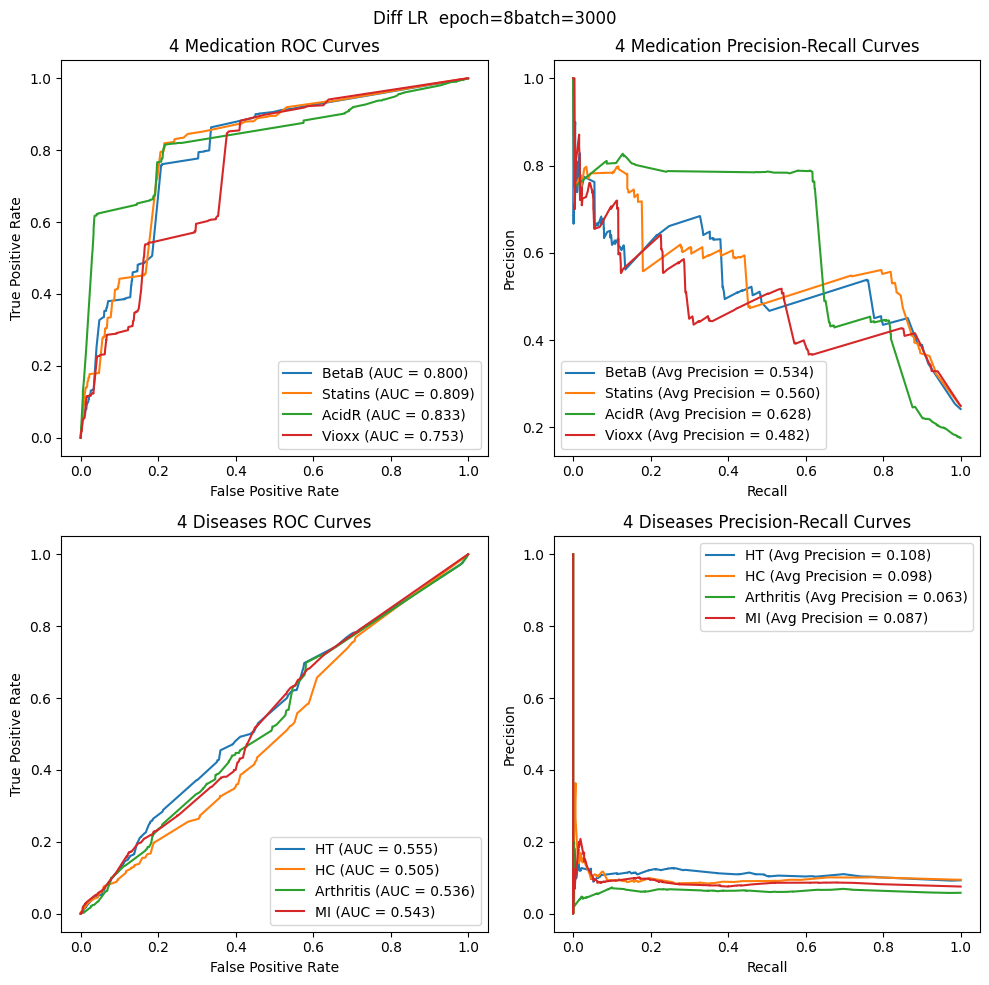

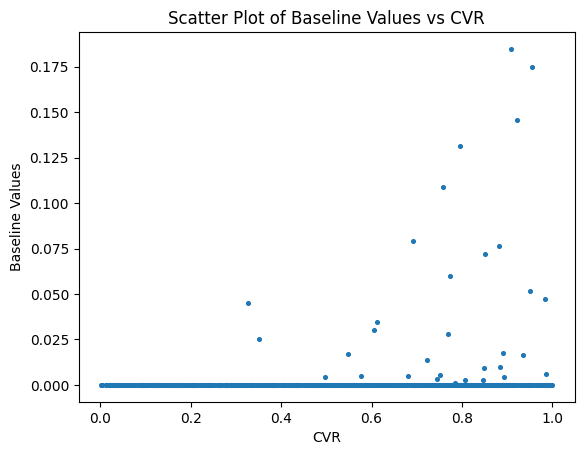

0.0


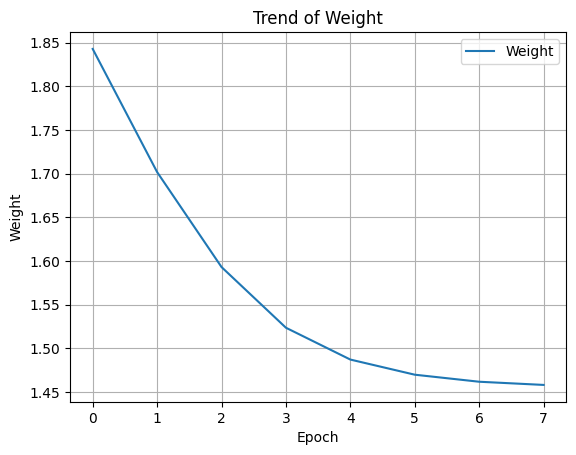

In [70]:
# Set the model to evaluation mode, which affects layers like dropout and batch norm
model.eval()

# Initialize lists to store true labels and predicted outputs
y_label = []
y_pred = []

# Disable gradient calculation for efficiency during evaluation
with torch.no_grad():
    # Iterate over the validation data loader
    for batch in val_dlr:
        inputs = batch['input'].float()        # Extract input features from the batch
        labels = batch['output'].float()       # Extract true labels from the batch
        patient_ids = batch['patient_id']      # Extract patient IDs, if necessary for the model

        # Get model predictions
        outputs = model(inputs, patient_ids)

        # Append true labels and predictions to their respective lists
        y_label.extend(labels.numpy())  # Convert labels to numpy array and add to list
        y_pred.extend(outputs.numpy())  # Convert predictions to numpy array and add to list

# Convert lists to numpy arrays for easier manipulation
y_label_np = np.stack(y_label)  # Stack list of arrays into a single numpy array
y_pred_np = np.stack(y_pred)    # Stack list of arrays into a single numpy array

# Plot ROC and Precision-Recall curves
plot_roc_pr_curves(y_label_np, y_pred_np, events, title)

# Extract baseline values from the model's parameters
baseline_values = model.baseline_hidden_unit.detach().numpy()  # Detach from the computation graph and convert to numpy
sorted_values = np.sort(baseline_values)  # Sort baseline values for analysis
cvr = pat_array[:, 0, 1]  # Extract CVR (Cardiovascular Risk) from the patient array

# Plot the baseline values against CVR to visualize their relationship
plt.scatter(cvr, baseline_values, s=7)  # Scatter plot with small marker size
plt.title('Scatter Plot of Baseline Values vs CVR')  # Title of the plot
plt.xlabel('CVR')  # X-axis label
plt.ylabel('Baseline Values')  # Y-axis label
plt.show()  # Display the plot

# Print the baseline value at index 100 in the sorted values
print(sorted_values[100])

# Plot the trend of the baseline_to_MI_weight parameter across epochs
plt.plot(weight_list, label='Weight')  # Plot the weight trend over epochs
plt.title('Trend of Weight')  # Title of the plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Weight')  # Y-axis label
plt.legend()  # Add a legend
plt.grid(True)  # Show grid lines
plt.show()  # Display the plot
